<a href="https://colab.research.google.com/github/gi1no/Education/blob/main/ThinkStats/chap14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

(chapter_analytic_methods)=
# Analytic Methods

This book has focused on computational methods like simulation and resampling, but some of the problems we solved have analytic solutions that can be much faster to compute.

This chapter presents some of these methods and explains how they work.
At the end of the chapter, I make suggestions for integrating computational and analytic methods for data analysis.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap14.ipynb).

In [64]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [65]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Normal Probability Plots

Many analytic methods are based on the properties of the normal distribution, for two reasons: distributions of many measurements in the real world are well-approximated by normal distributions, and normal distributions have mathematical properties that make them useful for analysis.

To demonstrate the first point, we'll look at some of the measurements in the penguin dataset.
Then we'll explore the mathematical properties of the normal distribution.
Instructions for downloading the data are in the notebook for this chapter.

The following cell downloads the data from a repository created by Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

The data was collected as part of the research that led to this paper: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

In [67]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

We can read the data like this.

In [68]:
penguins = pd.read_csv("penguins_raw.csv")
penguins.shape

(344, 17)

The dataset contains measurements from three penguin species.
For this example, we'll select the Adélie penguins.

In [69]:
adelie = penguins.query('Species.str.startswith("Adelie")').copy()
len(adelie)

152

To see if penguin weights follow a normal distribution, we'll compute the empirical CDF of the data.

In [70]:
from empiricaldist import Cdf

weights = adelie["Body Mass (g)"].dropna()
cdf_weights = Cdf.from_seq(weights)

And we'll compute the analytic CDF of a normal distribution with the same mean and standard deviation.

In [71]:
m, s = weights.mean(), weights.std()
m, s

(np.float64(3700.662251655629), 458.5661259101347)

In [72]:
from scipy.stats import norm

dist = norm(m, s)
qs = np.linspace(m - 3.5 * s, m + 3.5 * s)
ps = dist.cdf(qs)

Here's what the CDF of the data looks like compared to the normal model.

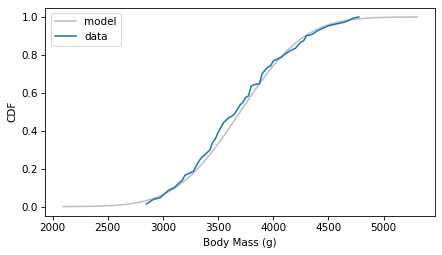

In [73]:
model_options = dict(color="gray", alpha=0.5, label="model")
plt.plot(qs, ps, **model_options)
cdf_weights.plot(label="data")

decorate(ylabel="CDF")

The normal distribution might be a good enough model of this data, but it's certainly not a perfect fit.

In general, plotting the CDF of the data and the CDF of a model is a good way to evaluate how well the model fits the data.
But one drawback of this method is that it depends on how well we estimate the parameters of the model -- in this example, the mean and standard deviation.

An alternative is a **normal probability plot**, which does not depend on our ability to estimate parameters.
In a normal probability plot the $y$ values are the sorted measurements.

In [74]:
ys = np.sort(weights)

And the $x$ values are the corresponding percentiles of a normal distribution, computed using the `ppf` method of the `norm` object, which computes the "percent point function", which is the inverse CDF.

In [75]:
n = len(weights)
ps = (np.arange(n) + 0.5) / n
xs = norm.ppf(ps)

If the measurements are actually drawn from a normal distribution, the $y$ and $x$ values should fall on a straight line.
To see how well they do, we can use `linregress` to fit a line.

In [76]:
from scipy.stats import linregress

results = linregress(xs, ys)
intercept, slope = results.intercept, results.slope

fit_xs = np.linspace(-3, 3)
fit_ys = intercept + slope * fit_xs

The following figure shows the $x$ and $y$ values along with the fitted line.

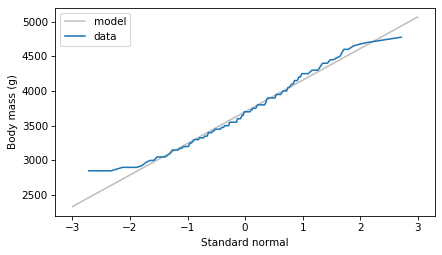

In [77]:
plt.plot(fit_xs, fit_ys, **model_options)
plt.plot(xs, ys, label="data")

decorate(xlabel="Standard normal", ylabel="Body mass (g)")

The normal probability plot is not a perfectly straight line, which indicates that the normal distribution is not a perfect model for this data.

One reason is that the dataset includes male and female penguins, and the two groups have different means -- let's see what happens if we plot the groups separately.
The following function encapsulates the steps we used to make a normal probability plot.

In [78]:
def normal_probability_plot(sample, **options):
    """Makes a normal probability plot with a fitted line."""
    n = len(sample)
    ps = (np.arange(n) + 0.5) / n
    xs = norm.ppf(ps)
    ys = np.sort(sample)

    results = linregress(xs, ys)
    intercept, slope = results.intercept, results.slope

    fit_xs = np.linspace(-3, 3)
    fit_ys = intercept + slope * fit_xs

    plt.plot(fit_xs, fit_ys, color="gray", alpha=0.5)
    plt.plot(xs, ys, **options)
    decorate(xlabel="Standard normal")

Here's what the results look like for male and female penguins separately.

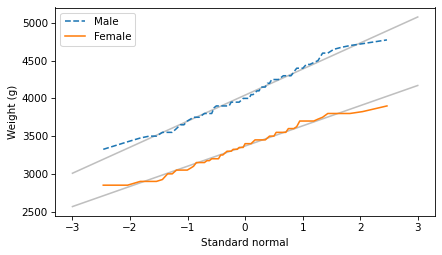

In [79]:
grouped = adelie.groupby("Sex")

weights_male = grouped.get_group("MALE")["Body Mass (g)"]
normal_probability_plot(weights_male, ls="--", label="Male")

weights_female = grouped.get_group("FEMALE")["Body Mass (g)"]
normal_probability_plot(weights_female, label="Female")

decorate(ylabel="Weight (g)")

The normal probability plots for both groups are close to a straight line, which indicates that the distributions of weight follow normal distributions.
When we put the groups together, the distribution of their weights is a mixture of two normal distributions with different means -- and a mixture like that is not always well modeled by a normal distribution.

Now let's consider some of the mathematical properties of normal distributions that make them so useful for analysis.

## Normal Distributions

The following class defines an object that represents a normal distribution.
It contains as attributes the parameters `mu` and `sigma2`, which represent the mean and variance of the distribution.
The name `sigma2` is a reminder that variance is the square of the standard deviation, which is usually denoted `sigma`.

In [80]:
class Normal:
    """Represents a Normal distribution"""

    def __init__(self, mu, sigma2):
        """Make a Normal object.

        mu: mean
        sigma2: variance
        """
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        """Returns a string representation."""
        return f"Normal({self.mu}, {self.sigma2})"

    __str__ = __repr__

As an example, we'll create a `Normal` object that represents a normal distribution with the same mean and variance as the weights of the male penguins.

In [81]:
m, s = weights_male.mean(), weights_male.std()
dist_male = Normal(m, s**2)
dist_male

Normal(4043.4931506849316, 120278.25342465758)

And another `Normal` object with the same mean and variance as the weights of the female penguins.

In [82]:
m, s = weights_female.mean(), weights_female.std()
dist_female = Normal(m, s**2)
dist_female

Normal(3368.8356164383563, 72565.63926940637)

Next we'll add a method to the `Normal` class that generates a random sample from a normal distribution.
To add methods to an existing class, we'll use a Jupyter magic command, `add_method_to`, which is defined in the `thinkstats` module.
This command is not part of Python -- it only works in Jupyter notebooks.

In [83]:
%%add_method_to Normal


def sample(self, n):
    """Generate a random sample from this distribution."""
    sigma = np.sqrt(self.sigma2)
    return np.random.normal(self.mu, sigma, n)

We'll use `sample` to demonstrate the first useful property of a normal distribution: if you draw values from two normal distributions and add them, the distribution of the sum is also normal.

As an example, we'll generate samples from the `Normal` objects we just made, add them together, and make a normal probability plot of the sums.

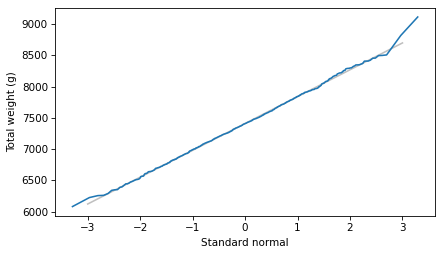

In [84]:
sample_sum = dist_male.sample(1000) + dist_female.sample(1000)
normal_probability_plot(sample_sum)

decorate(ylabel="Total weight (g)")

The normal probability plot looks like a straight line, which indicates that the sums follow a normal distribution.
And that's not all -- if we know the parameters of the two distributions, we can compute the parameters of the distribution of the sum.
The following method shows how.

In [85]:
%%add_method_to Normal


def __add__(self, other):
    """Distribution of the sum of two normal distributions."""
    return Normal(self.mu + other.mu, self.sigma2 + other.sigma2)

In the distribution of the sum, the mean is the sum of the means and the variance is the sum of the variances.
Now that we've defined the special method `__add__`, we can use the `+` operator to "add" two distributions -- that is, to compute the distribution of their sum.

In [86]:
dist_sum = dist_male + dist_female
dist_sum

Normal(7412.328767123288, 192843.89269406395)

To confirm that this result is correct, we'll use the following method, which plots the analytic CDF of a normal distribution.

In [87]:
%%add_method_to Normal


def plot_cdf(self, n_sigmas=3.5, **options):
    """Plot the CDF of this distribution."""
    mu, sigma = self.mu, np.sqrt(self.sigma2)
    low, high = mu - n_sigmas * sigma, mu + n_sigmas * sigma
    xs = np.linspace(low, high, 101)
    ys = norm.cdf(xs, mu, sigma)
    plt.plot(xs, ys, **options)

Here's the result along with the empirical CDF of the sum of the random samples.

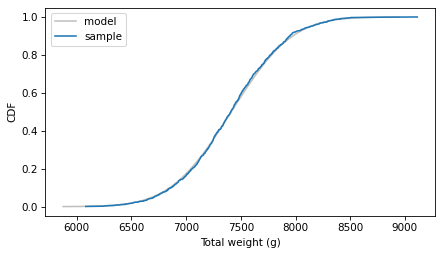

In [88]:
dist_sum.plot_cdf(**model_options)
Cdf.from_seq(sample_sum).plot(label="sample")

decorate(xlabel="Total weight (g)", ylabel="CDF")

It looks like the parameters we computed are correct, which confirms that we can add two normal distributions by adding their means and variances.

As a corollary, if we generate `n` values from a normal distribution and add them up, the distribution of the sum is also a normal distribution.
To demonstrate, we'll start by generating 73 values from the distribution of male weights and adding them up.
The following loop does that 1001 times, so the result is a sample from the distribution of sums.

In [89]:
n = len(weights_male)
sample_sums_male = [dist_male.sample(n).sum() for i in range(1001)]
n

73

The following method makes a `Normal` object that represents the distribution of the sums.
To compute the parameters, we multiply both the mean and variance by `n`.

In [90]:
%%add_method_to Normal


def sum(self, n):
    """Return the distribution of the sum of n values."""
    return Normal(n * self.mu, n * self.sigma2)

Here's the distribution of the sum of `n` weights.

In [91]:
dist_sums_male = dist_male.sum(n)

And here's how it compares to the empirical distribution of the random sample.

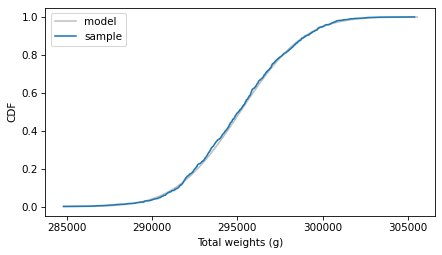

In [92]:
dist_sums_male.plot_cdf(**model_options)
Cdf.from_seq(sample_sums_male).plot(label="sample")

decorate(xlabel="Total weights (g)", ylabel="CDF")

The analytic distribution fits the distribution of the sample, which confirms that the `sum` method is correct.
So if we collect a sample of `n` measurements, we can compute the distribution of their sum.

## Distribution of Sample Means

If we can compute the distribution of a sample sum, we can also compute the distribution of a sample mean.
To do that, we'll use a third property of a normal distribution: if we multiply or divide by a constant, the result is a normal distribution.
The following methods show how we compute the parameters of the distribution of a product or quotient.

In [93]:
%%add_method_to Normal


def __mul__(self, factor):
    """Multiplies by a scalar."""
    return Normal(factor * self.mu, factor**2 * self.sigma2)

In [94]:
%%add_method_to Normal


def __truediv__(self, factor):
    """Divides by a scalar."""
    return self * (1 / factor)

To compute the distribution of the product we multiply the mean by `factor` and the variance by the square of `factor`.
We can use this property to compute the distribution of the sample means.

In [95]:
dist_mean_male = dist_sums_male / n

To see if the result is correct, we'll also compute the means of the random samples.

In [96]:
sample_means_male = np.array(sample_sums_male) / n

And compare the normal model to the empirical CDF of the sample means.

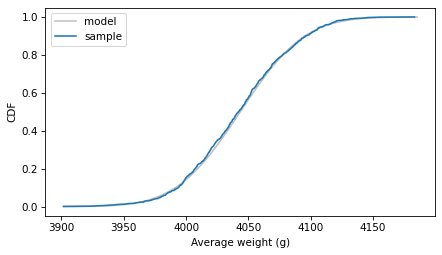

In [97]:
dist_mean_male.plot_cdf(**model_options)
Cdf.from_seq(sample_means_male).plot(label="sample")

decorate(xlabel="Average weight (g)", ylabel="CDF")

The model and the simulation results agree, which shows that we can compute the distribution of the sample means analytically -- which is very fast, compared to resampling.

Now that we know the sampling distribution of the mean, we can use it to compute the standard error, which is the standard deviation of the sampling distribution.

In [98]:
standard_error = np.sqrt(dist_mean_male.sigma2)
standard_error

np.float64(40.59122204599278)

This result suggests a shortcut we can use to compute the standard error directly, without computing the sampling distribution.
In the sequence of steps we followed, we multiplied the variance by `n` and then divided by `n**2` -- the net effect was to divide the variance by `n`, which means we divided the standard deviation by the square root of `n`.

So we can compute the standard error of the sample mean like this.

In [99]:
standard_error = weights_male.std() / np.sqrt(n)
standard_error

np.float64(40.59122204599278)

Now let's consider one more result we can compute with normal distributions, the distribution of differences.

## Distribution of Differences

Putting together the steps from the previous section, here's how we can compute the distribution of sample means for the weights of the female penguins.

In [100]:
n = len(weights_female)
dist_mean_female = dist_female.sum(n) / n
dist_mean_female

Normal(3368.835616438356, 994.0498530055667)

Now we have sampling distributions for the average weight of male and female penguins -- let's compute the distribution of the differences.
The following method computes the distribution of the difference between values from two normal distributions.

In [101]:
%%add_method_to Normal


def __sub__(self, other):
    """Compute the distribution of a difference."""
    return Normal(self.mu - other.mu, self.sigma2 + other.sigma2)

As you might expect, the mean of the differences is the difference of the means.
But as you might not expect, the variance of the differences is not the difference of the variances -- it's the sum!
To see why, imagine we perform subtraction in two steps:

* If we negate the second distribution, the mean is negated but the variance is the same.

* Then if we add in the first distribution, the variance of the sum is the sum of the variances.

If that doesn't convince you, let's test it.
Here's the analytic distribution of the differences.

In [102]:
dist_diff_means = dist_mean_male - dist_mean_female
dist_diff_means

Normal(674.6575342465753, 2641.6971601926566)

And here's a random sample of differences.

In [103]:
sample_sums_female = [dist_female.sample(n).sum() for i in range(1001)]
sample_means_female = np.array(sample_sums_female) / n
sample_diff_means = sample_means_male - sample_means_female

The following figure shows the empirical CDF of the random sample and the analytic CDF of the normal distribution.

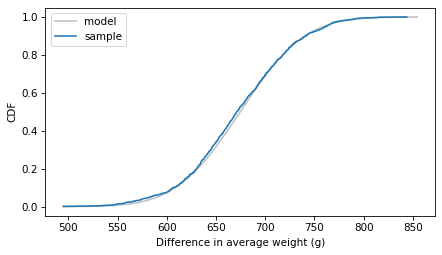

In [104]:
dist_diff_means.plot_cdf(**model_options)
Cdf.from_seq(sample_diff_means).plot(label="sample")

decorate(xlabel="Difference in average weight (g)", ylabel="CDF")

They agree, which confirms that we found the distribution of the differences correctly.
We can use this distribution to compute a confidence interval for the difference in weights.
We'll use the following method to compute the inverse CDF.

In [105]:
%%add_method_to Normal


def ppf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.ppf(xs, self.mu, sigma)

The 5th and 95th percentiles form a 90% confidence interval.

In [106]:
ci90 = dist_diff_means.ppf([0.05, 0.95])
ci90

array([590.1162635 , 759.19880499])

We get approximately the same results from the random sample.

In [107]:
np.percentile(sample_diff_means, [5, 95])

array([583.63021258, 761.43757695])

The analytic method is faster than resampling, and it is deterministic -- that is, not random.

However, everything we've done so far is based on the assumption that the distribution of measurements is normal.
That's not always true -- in fact, with real data it is never exactly true.
But even if the distribution of the measurements isn't normal, if we add up many measurements, the distribution of their sum is often close to normal.
That is the power of the Central Limit Theorem.

(section_central_limit_theorem)=
## Central Limit Theorem

As we saw in the previous sections, if we add values drawn from normal distributions, the distribution of the sum is normal.
Most other distributions don't have this property -- for example, if we add values drawn from an exponential distribution, the distribution of the sum is not exponential.

But for many distributions, if we generate `n` values and add them up, the distribution of the sum converges to normal as `n` increases.
More specifically, if the distribution of the values has mean `m` and variance `s2` the distribution of the sum converges to a normal distribution with mean `n * m` and variance `n * s2`.

That conclusion is the Central Limit Theorem (CLT).
It is one of the most useful tools for statistical analysis, but it comes with caveats:

-   The values have to come from the same distribution (although this requirement can be relaxed).

-   The values have to be drawn independently. If they are correlated, the CLT doesn't apply (although it can still work if the correlation is not too strong).

-   The values have to be drawn from a distribution with finite mean and variance. So the CLT doesn't apply to some long-tailed distributions.

The Central Limit Theorem explains the prevalence of normal distributions in the natural world.
Many characteristics of living things are affected by genetic and environmental factors whose effect is additive.
The characteristics we measure are the sum of a large number of small effects, so their distribution tends to be normal.

To see how the Central Limit Theorem works, and when it doesn't, let's try some experiments,
starting with an exponential distribution.
The following loop generates samples from an exponential distribution, adds them up, and makes a dictionary that maps from each sample size, `n`, to a list of 1001 sums.

In [108]:
np.random.seed(17)

In [109]:
lam = 1
df_sample_expo = pd.DataFrame()
for n in [1, 10, 100]:
    df_sample_expo[n] = [np.sum(np.random.exponential(lam, n)) for _ in range(1001)]

Here are the averages for each list of sums.

In [110]:
df_sample_expo.mean()

,0
1,0.989885
10,9.825744
100,100.022555


The average value from this distribution is 1, so if we add up 10 values, the average of the sum is close to 10, and if we add up 100 values the average of the sum is close to 100.

This function takes the `DataFrame` we just made and makes a normal probability plot for each list of sums.

In [111]:
def normal_plot_samples(df_sample, ylabel=""):
    """Normal probability plots for samples of sums."""
    plt.figure(figsize=(6.8, 2.6))
    for i, n in enumerate(df_sample):
        plt.subplot(1, 3, i + 1)
        normal_probability_plot(df_sample[n])
        decorate(
            title="n=%d" % n,
            xticks=[],
            yticks=[],
            xlabel="Standard normal",
            ylabel=ylabel,
        )

The following figure shows normal probability plots for the three lists of sums (the definition of `normal_plot_samples` is in the notebook for this chapter).

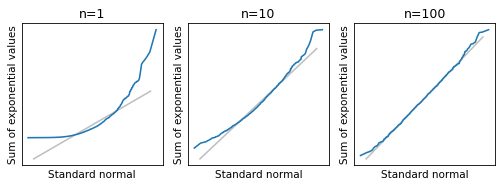

In [112]:
normal_plot_samples(df_sample_expo, ylabel="Sum of exponential values")

When `n=1`, the distribution of the sum is exponential, so the normal probability plot is not a straight line.
But with `n=10` the distribution of the sum is approximately normal, and with `n=100` it is almost indistinguishable from normal.

For distributions that are less skewed than an exponential, the distribution of the sum converges to normal more quickly -- that is, for smaller values of `n`.
For distributions that are more skewed, it takes longer.
As an example, let's look at sums of values from a lognormal distribution.

In [113]:
mu, sigma = 3.0, 1.0
df_sample_lognormal = pd.DataFrame()
for n in [1, 10, 100]:
    df_sample_lognormal[n] = [
        np.sum(np.random.lognormal(mu, sigma, n)) for _ in range(1001)
    ]

Here are the normal probability plots for the same range of sample sizes.

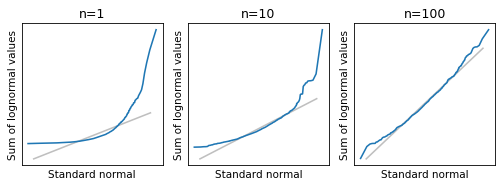

In [114]:
normal_plot_samples(df_sample_lognormal, ylabel="Sum of lognormal values")

When `n=1`, a normal model does not fit the distribution, and it is not much better with `n=10`.
Even with `n=100`, the tails of the distribution clearly deviate from the model.

The mean and variance of the lognormal distribution are finite, so the distribution of the sum converges to normal eventually.
But for some highly skewed distributions, it might not converge at any practical sample size.
And in some cases, it doesn't happen at all.

## The Limits of the Central Limit Theorem

Pareto distributions are even more skewed than lognormal.
Depending on the parameters, some Pareto distributions do not have finite mean and variance -- in those cases, the Central Limit Theorem does not apply.

To demonstrate, we'll generate values from a Pareto distribution with parameter `alpha=1`, which has infinite mean and variance.

In [115]:
alpha = 1.0
df_sample = pd.DataFrame()
for n in [1, 10, 100]:
    df_sample[n] = [np.sum(np.random.pareto(alpha, n)) for _ in range(1001)]

Here's what the normal probability plots look like for a range of sample sizes.

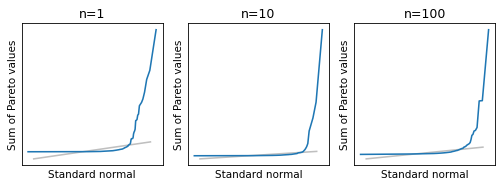

In [116]:
normal_plot_samples(df_sample, ylabel="Sum of Pareto values")

Even with `n=100`, the distribution of the sum is nothing like a normal distribution.

I also mentioned that the CLT does not apply if the values are correlated.
To test that, we'll use a function called `generate_expo_correlated` to generate values from an exponential distribution where the serial correlation -- that is, the correlation between successive elements in the sample -- is the given value, `rho`.
This function is defined in the notebook for this chapter.

In [117]:
def generate_normal_correlated(n, rho):
    """Generates an array of correlated values from a standard normal dist."""
    xs = np.empty(n)
    xs[0] = np.random.normal(0, 1)

    sigma = np.sqrt(1 - rho**2)
    for i in range(1, n):
        xs[i] = rho * xs[i - 1] + np.random.normal(0, sigma)

    return xs

Given a correlated sequence from a normal distribution, the following function generates a correlated sequence from an exponential distribution.

In [118]:
from scipy.stats import expon


def generate_expo_correlated(n, rho):
    """Generates a sequence of correlated values from an exponential dist."""
    normal = generate_normal_correlated(n, rho)
    uniform = norm.cdf(normal)
    expo = expon.ppf(uniform)
    return expo

It starts with a sequence of correlated normal values and uses the normal CDF to transform them to a sequence of values from a uniform distribution between 0 and 1.
Then it uses the exponential inverse CDF to transform them to a sequence of exponential values.

The following loop makes a `DataFrame` with one column for each sample size and 1001 sums in each column.

In [119]:
rho = 0.8
df_sample = pd.DataFrame()
for n in [1, 10, 100]:
    df_sample[n] = [np.sum(generate_expo_correlated(n, rho)) for _ in range(1001)]

Here are the normal probability plots for the distribution of these sums.

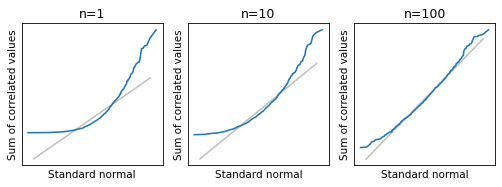

In [120]:
normal_plot_samples(df_sample, ylabel="Sum of correlated values")

With `rho=0.8`, there is a strong correlation between successive elements, and the distribution of the sum converges slowly.
If there is also a strong correlation between distant elements of the sequence, it might not converge at all.

The previous section shows that the Central Limit Theorem works, and this section shows what happens when it doesn't.
Now let's see how we can use it.

## Applying the CLT

To see why the Central Limit Theorem is useful, let's get back to the example in [Chapter 9](section_diff_means): testing the apparent difference in mean pregnancy length for first babies and others.
We'll use the NSFG data again -- instructions for downloading it are in the notebook for this chapter.

The following cell downloads the data.

In [121]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

We'll use `get_nsfg_groups` to read the data and divide it into first babies and others.

In [122]:
!pip install  statadict
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

As we've seen, first babies are born a little later, on average -- the apparent difference is about 0.078 weeks.

In [123]:
delta = firsts["prglngth"].mean() - others["prglngth"].mean()
delta

np.float64(0.07803726677754952)

To see whether this difference might have happened by chance, we'll assume as a null hypothesis that the mean and variance of pregnancy lengths is actually the same for both groups, so we can estimate it using all live births.

In [124]:
all_lengths = live["prglngth"]
m, s2 = all_lengths.mean(), all_lengths.var()

The distribution of pregnancy lengths does not follow a normal distribution -- nevertheless, we can use a normal distribution to approximate the sampling distribution of the mean.

The following function takes a sequence of values and returns a `Normal` object that represents the sampling distribution of the mean of a sample with the given size, `n`, drawn from a normal distribution with the same mean and variance as the data.

In [125]:
def sampling_dist_mean(data, n):
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.sum(n) / n

Here's a normal approximation to the sampling distribution of mean weight for first births, under the null hypothesis.

In [126]:
n1 = firsts["totalwgt_lb"].count()
dist_firsts = sampling_dist_mean(all_lengths, n1)
n1

np.int64(4363)

And here's the sampling distribution for other babies.

In [127]:
n2 = others["totalwgt_lb"].count()
dist_others = sampling_dist_mean(all_lengths, n2)
n2

np.int64(4675)

We can compute the sampling distribution of the difference like this.

In [128]:
dist_diff = dist_firsts - dist_others
dist_diff

Normal(0.0, 0.0032358375679305716)

The mean is 0, which makes sense because if we draw two samples from the same distribution, we expect the difference in means to be 0, on average.
The variance of the sampling distribution is 0.0032, which indicates how much variation we expect in the difference due to chance.

To confirm that this distribution approximates the sampling distribution, we can also estimate it by resampling.

In [129]:
sample_firsts = [np.random.choice(all_lengths, n1).mean() for i in range(1001)]
sample_others = [np.random.choice(all_lengths, n2).mean() for i in range(1001)]
sample_diffs = np.subtract(sample_firsts, sample_others)

Here's the empirical CDF of the resampled differences compared to the normal model.
The vertical dotted lines show the observed difference, positive and negative.

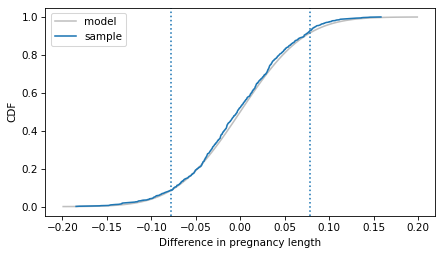

In [130]:
dist_diff.plot_cdf(**model_options)
Cdf.from_seq(sample_diffs).plot(label="sample")
plt.axvline(delta, ls=":")
plt.axvline(-delta, ls=":")

decorate(xlabel="Difference in pregnancy length", ylabel="CDF")

In this example, the sample sizes are large and the skewness of the measurements is modest, so the sampling distribution is well approximated by a normal distribution.
Therefore, we can use the normal CDF to compute a p-value.
The following method computes the CDF of a normal distribution.

In [131]:
%%add_method_to Normal


def cdf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.cdf(xs, self.mu, sigma)

Here's the probability of a difference as large as `delta` under the null hypothesis, which is the area under the right tail of the sampling distribution.

In [132]:
right = 1 - dist_diff.cdf(delta)
right

np.float64(0.08505405315527037)

And here's the probability of a difference as negative as `-delta`, which is the area under the left tail.

In [133]:
left = dist_diff.cdf(-delta)
left

np.float64(0.08505405315527031)

`left` and `right` are the same because the normal distribution is symmetric.
The sum of the two is the probability of a difference as large as `delta`, positive or negative.

In [134]:
left + right

np.float64(0.17010810631054069)

The resulting p-value is 0.170, which is consistent with the estimate we computed by resampling in [Chapter 9](section_diff_means).

The way we computed this p-value is similar to an **independent sample $t$ test**.
SciPy provides a function called `ttest_ind` that takes two samples and computes a p-value for the difference in their means.

In [135]:
from scipy.stats import ttest_ind

result = ttest_ind(firsts["prglngth"], others["prglngth"])
result.pvalue

np.float64(0.16755412639415004)

When the sample sizes are large, the result of the $t$ test is close to what we computed with normal distributions.
The $t$ test is so called because it is based on a **t distribution** rather than a normal distribution.
The $t$ distribution is also useful for testing whether a correlation is statistically significant, as we'll see in the next section.

## Correlation Test

In [Chapter 9](section_test_correlation) we used a permutation test for the correlation between birth weight and mother's age, and found that it is statistically significant, with p-value less than 0.001.

Now we can do the same thing analytically.
The method is based on this mathematical result: If we generate two samples with size `n` from normal distributions, compute Pearson's correlation, `r`, and then transform the correlation with this function:

In [136]:
def transform_correlation(r, n):
    return r * np.sqrt((n - 2) / (1 - r**2))

The transformed correlations follow a $t$ distribution with parameter `n-2`.
To see what that looks like, we'll use the following function to generate uncorrelated samples from a standard normal distribution.

In [137]:
def generate_data(n):
    """Uncorrelated sequences from a standard normal."""
    xs = np.random.normal(0, 1, n)
    ys = np.random.normal(0, 1, n)
    return xs, ys

And the following function to compute their correlation.

In [138]:
def correlation(data):
    xs, ys = data
    return np.corrcoef(xs, ys)[0, 1]

The following loop generates many pairs of samples, computes their correlation, and puts the results in a list.

In [139]:
n = 100
rs = [correlation(generate_data(n)) for i in range(1001)]

Next we'll compute the transformed correlations.

In [140]:
ts = transform_correlation(np.array(rs), n)

To check whether these `ts` follow a $t$ distribution, we'll use the following function, which makes an object that represents the CDF of a $t$ distribution.

In [141]:
from scipy.stats import t as student_t


def make_student_cdf(df):
    """Computes the CDF of a Student t distribution."""
    ts = np.linspace(-3, 3, 101)
    ps = student_t.cdf(ts, df=df)
    return Cdf(ps, ts)

The parameter of the $t$ distribution is called `df`, which stands for "degrees of freedom".
The following figure shows the CDF of a $t$ distribution with parameter `n-2` along with the empirical CDF of the transformed correlations.

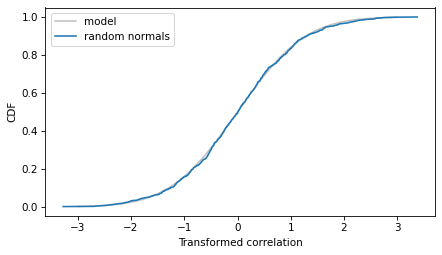

In [142]:
make_student_cdf(df=n - 2).plot(**model_options)

cdf_ts = Cdf.from_seq(ts)
cdf_ts.plot(label="random normals")

decorate(xlabel="Transformed correlation", ylabel="CDF")

This shows that if we draw uncorrelated samples from normal distributions, their transformed correlations follow a $t$ distribution.

If we draw samples from other distributions, their transformed correlations don't follow a $t$ distribution exactly, but they converge to a $t$ distribution as the sample size increases.
Let's see if this applies to the correlation of maternal age and birth weight.
From the `DataFrame` of live births, we'll select the rows with valid data.

In [143]:
valid = live.dropna(subset=["agepreg", "totalwgt_lb"])
n = len(valid)
n

9038

The actual correlation is about 0.07.

In [144]:
data = valid["agepreg"].values, valid["totalwgt_lb"].values
r_actual = correlation(data)
r_actual

np.float64(0.0688339703541091)

As we did in [Chapter 9](section_test_correlation), we can simulate the null hypothesis by permuting the samples.

In [145]:
def permute(data):
    """Shuffle the x values."""
    xs, ys = data
    new_xs = xs.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

If we generate many permutations and compute their correlations, the result is a sample from the distribution of correlations under the null hypothesis.

In [146]:
permuted_corrs = [correlation(permute(data)) for i in range(1001)]

And we can compute the transformed correlations like this.

In [147]:
ts = transform_correlation(np.array(permuted_corrs), n)

The following figure shows the empirical CDF of the `ts` along with the CDF of the $t$ distribution with parameter `n-2`.

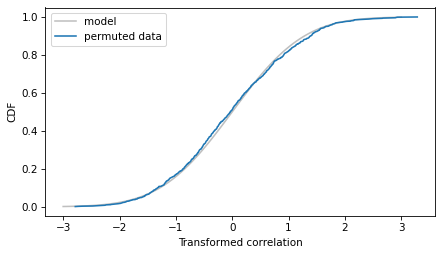

In [148]:
make_student_cdf(n - 2).plot(**model_options)
Cdf.from_seq(ts).plot(label="permuted data")

decorate(xlabel="Transformed correlation", ylabel="CDF")

The model fits the empirical distribution well, which means we can use it to compute a p-value for the observed correlation.
First we'll transform the observed correlation.

In [149]:
t_actual = transform_correlation(r_actual, n)

Now we can use the CDF of the $t$ distribution to compute the probability of a value as large as `t_actual` under the null hypothesis.

In [150]:
right = 1 - student_t.cdf(t_actual, df=n - 2)
right

np.float64(2.861466619208386e-11)

We can also compute the probability of a value as negative as `-t_actual`.

In [151]:
left = student_t.cdf(-t_actual, df=n - 2)
left

np.float64(2.8614735536574016e-11)

The sum of the two is the probability of a correlation as big as `r_actual`, positive or negative.

In [152]:
left + right

np.float64(5.722940172865787e-11)

SciPy provides a function that does the same calculation and returns the p-value of the observed correlation.

In [153]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(*data)
p_value

np.float64(5.722947107314364e-11)

The results are nearly the same.

Based on the resampling results, we concluded that the p-value was less than 0.001, but we could not say how much less without running a very large number of resamplings.
With analytic methods, we can compute small p-values quickly.

However, in practice it might not matter.
Generally, if a p-value is smaller than 0.001, we can conclude that the observed effect is unlikely to be due to chance.
It is not usually important to know precisely how unlikely.

## Chi-squared Test

In [Chapter 9](section_testing_proportions) we tested whether a die is crooked, based on this set of observed outcomes.

In [154]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

,0
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


First we computed the expected frequency for each outcome.

In [155]:
num_rolls = observed.sum()
outcomes = observed.qs
expected = Hist(num_rolls / 6, outcomes)

Then we used the following function to compute the chi-squared statistic.

In [156]:
def chi_squared_stat(observed, expected):
    diffs = (observed - expected) ** 2
    ratios = diffs / expected
    return np.sum(ratios.values.flatten())

In [157]:
observed_chi2 = chi_squared_stat(observed, expected)

The chi-squared statistic is widely used for this kind of data because its sampling distribution under the null hypothesis converges to a distribution we can compute efficiently -- not coincidentally, it is called a **chi-squared distribution**.
To see what it looks like, we'll use the following function, which simulates rolling a fair die.

In [158]:
def simulate_dice(observed):
    n = np.sum(observed)
    rolls = np.random.choice(observed.qs, n, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

The following loop runs the simulation many times and computes the chi-squared statistic of the outcomes.

In [159]:
simulated_chi_squared = [
    chi_squared_stat(simulate_dice(observed), expected) for i in range(1001)
]
cdf_simulated = Cdf.from_seq(simulated_chi_squared)

To check whether the results follow a chi-squared distribution, we'll use the following function, which computes the CDF of a chi-squared distribution with parameter `df`.

In [160]:
from scipy.stats import chi2 as chi2_dist


def chi_squared_cdf(df):
    """Discrete approximation of the chi-squared CDF."""
    xs = np.linspace(0, 21, 101)
    ps = chi2_dist.cdf(xs, df=df)
    return Cdf(ps, xs)

With `n` possible outcomes, the simulated chi-squared statistics should follow a chi-squared distribution with parameter `n-1`.

In [161]:
n = len(observed)
cdf_model = chi_squared_cdf(df=n - 1)

Here's the empirical CDF of the simulated chi-squared statistics along with the CDF of the chi-squared distribution.

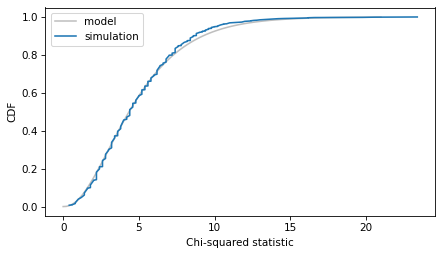

In [162]:
cdf_model.plot(**model_options)
cdf_simulated.plot(label="simulation")

decorate(xlabel="Chi-squared statistic", ylabel="CDF")

The model fits the simulation results well, so we can use it to compute the probability of a value as large as `observed_chi2` under the null hypothesis.

In [163]:
p_value = 1 - chi2_dist.cdf(observed_chi2, df=n - 1)
p_value

np.float64(0.04069938850404997)

SciPy provides a function that does the same computation.

In [164]:
from scipy.stats import chisquare

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

The result is the same as the p-value we computed.

In [165]:
p_value

np.float64(0.040699388504049985)

The advantage of the chi-squared statistic is that its distribution under the null hypothesis can be computed efficiently.
But in context, it might not be the statistic that best quantifies the difference between the observed and expected outcomes.

## Computation and Analysis

This book focuses on computational methods like resampling and permutation.
These methods have several advantages over analysis:

-   They are easier to explain and understand. For example, one of the most difficult topics in an introductory statistics class is hypothesis testing. Many students don't really understand what p-values are. I think the approach we took in [Chapter 9](chapter_hypothesis_testing) -- simulating the null hypothesis and computing test statistics -- makes the fundamental idea clearer.

-   They are robust and versatile. Analytic methods are often based on assumptions that don't hold in practice. Computational methods require fewer assumptions, and can be adapted and extended more easily.

-   They are debuggable. Analytic methods are often like a black box: you plug in numbers and they spit out results. But it's easy to make subtle errors, hard to be confident that the results are right, and hard to diagnose the problem if they are not. Computational methods lend themselves to incremental development and testing, which fosters confidence in the results.

But there are drawbacks:

* Computational methods can be slow.

* Randomized methods like resampling don't produce the same results every time, which makes it harder to check that they are correct.

Taking into account these pros and cons, I recommend the following process:

1.  Use computational methods during exploration. If you find a satisfactory answer and the run time is acceptable, you can stop.

2.  If run time is not acceptable, look for opportunities to optimize. Using analytic methods is one of several methods of optimization.

3.  If replacing a computational method with an analytic method is appropriate, use the computational method as a basis of comparison, providing mutual validation between the computational and analytic results.

For many practical problems, the run time of computational methods is not a problem, and we don't have to go past the first step.

## Glossary

- **normal probability plot:** A plot that compares observed values with the quantiles of a normal distribution to see how closely the data follow a normal distribution.

- **independent sample $t$ test:** A method for computing the p-value of an observed difference between the means of two independent groups.

- **$t$ distribution:** A distribution used to model the sampling distribution of a difference in means under the null hypothesis that the difference is 0, as well as the sampling distribution of transformed correlations.

- **chi-squared distribution:** A distribution used to model the sampling distribution of the chi-squared statistic.

- **chi-squared statistic:** A test statistic that quantifies the magnitude of the difference between two discrete distributions.

## Exercises

### Exercise 14.1

In this chapter we compared the weights of male and female penguins and computed a confidence interval for the difference.
Now let's do the same for flipper length.
The observed difference is about 4.6 mm.

In [166]:
grouped = adelie.groupby("Sex")

lengths_male = grouped.get_group("MALE")["Flipper Length (mm)"]
lengths_female = grouped.get_group("FEMALE")["Flipper Length (mm)"]
observed_diff = lengths_male.mean() - lengths_female.mean()
observed_diff

np.float64(4.616438356164366)

Use `sampling_dist_mean` to make `Normal` objects that represent sampling distributions for the mean flipper length in the two groups -- noting that the groups are not the same size.
Then compute the sampling distribution of the difference and a 90% confidence interval.

In [167]:
# Solution goes here

In [168]:
# Solution goes here

In [169]:
# Solution goes here

In [170]:
# Solution goes here

In [171]:
# Solution goes here

### Exercise 14.2

Using the NSFG data, we computed the correlation between a baby's birth weight and the mother's age, and we used a $t$ distribution to compute a p-value.
Now let's do the same with birth weight and father's age, which is recorded in the `hpagelb` column.

In [172]:
valid = live.dropna(subset=["hpagelb", "totalwgt_lb"])
n = len(valid)
n

8933

The observed correlation is about 0.065.

In [173]:
data = valid["hpagelb"].values, valid["totalwgt_lb"].values
r_actual = correlation(data)
r_actual

np.float64(0.06468629895432174)

Compute the transformed correlation, `t_actual`.
Use the CDF of the $t$ distribution to compute a p-value -- is this correlation statistically significant?
Use the SciPy function `pearsonr` to check your results.

In [174]:
# Solution goes here

In [175]:
# Solution goes here

In [176]:
# Solution goes here

### Exercise 14.3

In one of the exercises in [Chapter 9](chapter_hypothesis_testing) we considered the Trivers-Willard hypothesis, which suggests that for many mammals the sex ratio depends on "maternal condition" -- that is, factors like the mother's age, size, health, and social status.
Some studies have shown this effect among humans, but results are mixed.

As an example, and a chance to practice a chi-squared test, let's see if there's a relationship between the sex of a baby and the mother's marital status.
The notebook for this chapter has instructions to help you get started.

First we'll partition mothers of male and female babies.

In [177]:
male = live.query("babysex == 1")
female = live.query("babysex == 2")

Now we'll make a `DataFrame` with one column for each group and one row for each value of `fmarital`, which encodes marital status like this:

```
1  married
2  widowed
3  divorces
4  separated
5  never married
```

In [178]:
observed = pd.DataFrame()
observed["male"] = male["fmarital"].value_counts().sort_index()
observed["female"] = female["fmarital"].value_counts().sort_index()
observed

,male,female
fmarital,,
1,2576,2559
2,56,54
3,568,572
4,355,330
5,1086,985


The null hypothesis is that the distribution of marital status is the same for both groups, so we can use the whole dataset to compute it.

In [179]:
from empiricaldist import Pmf

pmf_fmarital = Pmf.from_seq(live["fmarital"])
pmf_fmarital

,
fmarital,
1,0.561653
2,0.012024
3,0.124617
4,0.075208
5,0.226498


To compute the expected values, we multiply the probabilities in `pmf_marital` by the total number of cases in each column.

In [180]:
expected = pd.DataFrame()
expected["male"] = pmf_fmarital * observed["male"].sum()
expected["female"] = pmf_fmarital * observed["female"].sum()
expected

,male,female
fmarital,,
1,2606.630739,2527.437691
2,55.805641,54.110188
3,578.349366,560.778312
4,349.038916,338.434631
5,1051.175339,1019.239178


Use `observed` and `expected` to compute a chi-squared statistic.
Then use the CDF of the chi-squared distribution to compute a p-value.
The degrees of freedom should be `n-1`, where `n` is the number of values in the observed `DataFrame`.
Then use the SciPy function `chisquared` to compute the chi-squared statistic and p-value.
Hint: use the argument `axis=None` to treat the entire `DataFrame` as a single test rather than one test for each column.

Does this test provide support for the Trivers-Willard hypothesis?

In [181]:
# Solution goes here

In [182]:
# Solution goes here

In [183]:
# Solution goes here

In [184]:
# Solution goes here

In [185]:
# Solution goes here

### Exercise 14.4

The method we used in this chapter to analyze differences between groups can be extended to analyze "differences in differences", which is a common experimental design.
As an example, we'll use data from a 2014 paper that investigates the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Stein, L. A., Aragon, D., Moreno, D., & Goodman, J. (2014, October). Evidence for the persistent effects of an intervention to mitigate gender-stereotypical task allocation within student engineering teams. In *2014 IEEE Frontiers in Education Conference (FIE) Proceedings* (pp. 1-9). IEEE.

Available from <http://ieeexplore.ieee.org/document/7044435/>.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the projects than female students: men reported an average score of 3.57 with standard error 0.28; women reported an average score of 1.91 with standard error 0.32.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16).

1. Make four `Normal` objects to represent the sampling distributions of the estimated means before and after the intervention, for both male and female students. Because we have standard errors for the estimated means, we don't need to know the sample size to get the parameters of the sampling distributions.

2. Compute the sampling distributions of the gender gap -- the difference in means -- before and after the intervention.

3. Then compute the sampling distribution of the difference in differences -- that is, the change in the size of the gap. Compute a 95% confidence interval and a p-value.

Is there evidence that the size of the gender gap decreased after the intervention?

In [186]:
# Solution goes here

In [187]:
# Solution goes here

In [188]:
# Solution goes here

In [189]:
# Solution goes here

In [190]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)